In [3]:
import numpy as np
import os
import cv2

import matplotlib.pyplot as plt

In [11]:
source_path = os.path.join('data', 'ara.png')
source = cv2.imread(source_path)
source = cv2.cvtColor(source, cv2.COLOR_BGR2RGB)

<Axes: title={'center': 'Исходник'}>

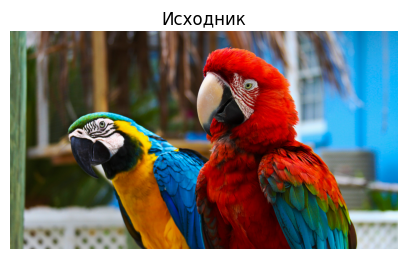

In [17]:
fig, ax = plt.subplots()
fig.set_size_inches(5, 7)
ax.imshow(source)
ax.set_title('Исходник')
ax.set_axis_off()
ax

In [8]:
print(f'image size is {source.shape}, image weight is {source.nbytes} bytes')

image size is (554, 987, 3), image weight is 1640394 bytes


In [21]:
source[0, 0, :]

array([ 84, 108,  80], dtype=uint8)

In [38]:
def RGB2YCrCb(source:np.ndarray)->np.ndarray:
    '''transforms RGB to YCrCb format'''
    matrix = np.array([
        [0.299, 0.587, 0.114],
        [0.5, -0.4187, -0.0813],
        [0.1687, -0.3313, 0.5]
    ])
    bias = np.array([0, 128, 128])

    dst = source@matrix + bias
    dst -= dst.min()
    dst /= dst.max()
    dst*=255.
    # print(dst.min())
    # print(dst.max())
    
    return dst.astype(np.uint8)

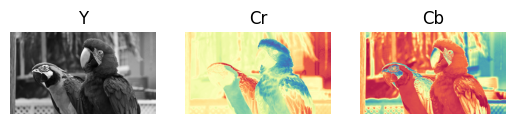

In [59]:
YCrCb = RGB2YCrCb(source)
fig, ax = plt.subplots(1, 3)
titles = ['Y', 'Cr', 'Cb']
cmaps = ['gray', 'Spectral', 'Spectral']
for i in range(3):
    ax[i].imshow(YCrCb[:, :, i], cmap = cmaps[i])
    ax[i].set_title(titles[i])
    ax[i].set_axis_off()
    

In [65]:
def get_every_second(source:np.ndarray)->np.ndarray:
    compressed = source[::2, ::2].copy()
    return compressed
Cr_compressed = get_every_second(YCrCb[:, :, 1])
Cb_compressed = get_every_second(YCrCb[:, :, 2])
# Cr_compressed.shape


In [67]:
def restore_img(compressed:np.ndarray, shape:tuple[int, int])->np.ndarray:
    '''restores image from compressed one '''
    restored = np.repeat(compressed, 2, axis = 0).copy()
    restored = np.repeat(restored, 2, axis = 1)
    return restored[:shape[0], :shape[1]]
Cr_restored = restore_img(Cr_compressed, YCrCb[:, :, 0].shape)
Cb_restored = restore_img(Cb_compressed, YCrCb[:, :, 0].shape)
Cb_restored.shape

(554, 987)

In [75]:
YCrCb_restored = np.stack((YCrCb[:, :, 0].copy(),  Cr_restored, Cb_restored), axis = -1)
YCrCb_restored.shape

(554, 987, 3)

In [77]:
print(f'images weight relation already is {(YCrCb[:, :, 0].copy().nbytes+Cr_compressed.nbytes+Cb_compressed.nbytes)/source.nbytes}')

images weight relation already is 0.5001688618709895


In [55]:
Cr_restored = np.repeat(Cr_compressed, 2, axis =0)
Cr_restored = np.repeat(Cr_restored, 2, axis = 1)
Cr_restored[:, :]

array([[119, 119, 115, ...,  32,  30,  30],
       [119, 119, 115, ...,  32,  30,  30],
       [120, 120, 116, ...,  29,  34,  34],
       ...,
       [130, 130, 128, ..., 101, 101, 101],
       [130, 130, 128, ..., 104, 101, 101],
       [130, 130, 128, ..., 104, 101, 101]], shape=(554, 988), dtype=uint8)